In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
cococola=pd.read_excel('CocaCola_Sales_Rawdata.xlsx')

In [3]:
quarter=['Q1','Q2','Q3','Q4']
n=cococola['Quarter'][0]
n[0:2]

'Q1'

In [4]:
cococola['quarter']=0

In [5]:
for i in range(42):
    n=cococola['Quarter'][i]
    cococola['quarter'][i]=n[0:2]

In [6]:
dummy=pd.DataFrame(pd.get_dummies(cococola['quarter']))

In [7]:
coco=pd.concat((cococola,dummy),axis=1)
t= np.arange(1,43)
coco['t']=t
coco['t_square']=coco['t']*coco['t']

In [8]:
log_Sales=np.log(coco['Sales'])
coco['log_Sales']=log_Sales

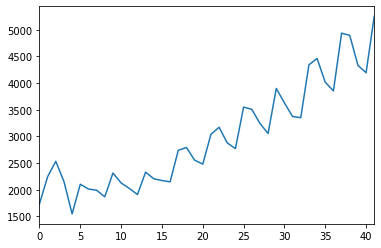

In [9]:
train= coco.head(38)
test=coco.tail(4)
coco.Sales.plot()

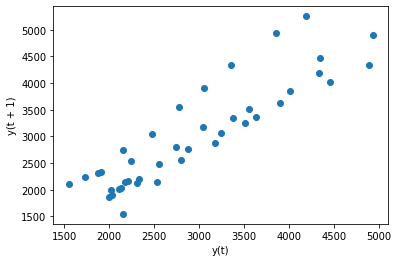

In [10]:
from pandas.plotting import lag_plot
lag_plot(coco['Sales'])
plt.show()

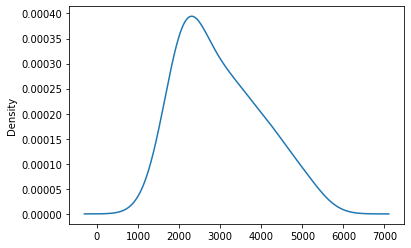

In [11]:
coco.Sales.plot(kind='kde')
plt.show()   #density plot

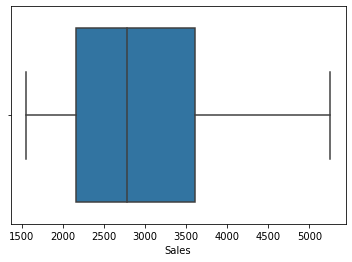

In [14]:
sns.boxplot("Sales",data=coco)

In [13]:
import statsmodels.formula.api as smf

#linear model
linear= smf.ols('Sales~t',data=train).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test['t'])))
rmselin=np.sqrt((np.mean(np.array(test['Sales'])-np.array(predlin))**2))
rmselin

421.17878760022813

In [14]:
#quadratic model
quad=smf.ols('Sales~t+t_square',data=train).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test[['t','t_square']])))
rmsequad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predquad))**2))
rmsequad

475.56183518315095

In [15]:
#exponential model
expo=smf.ols('log_Sales~t',data=train).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test['t'])))
predexp
rmseexpo=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predexp)))**2))
rmseexpo

466.24797310672346

In [16]:
#additive seasonality
additive= smf.ols('Sales~ Q1+Q2+Q3+Q4',data=train).fit()
predadd=pd.Series(additive.predict(pd.DataFrame(test[['Q1','Q2','Q3','Q4']])))
predadd
rmseadd=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predadd))**2))
rmseadd

1860.0238154547283

In [17]:
#additive seasonality with linear trend
addlinear= smf.ols('Sales~t+Q1+Q2+Q3+Q4',data=train).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(test[['t','Q1','Q2','Q3','Q4']])))
predaddlinear

rmseaddlinear=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predaddlinear))**2))
rmseaddlinear

464.98290239822427

In [18]:
#additive seasonality with quadratic trend
addquad=smf.ols('Sales~t+t_square+Q1+Q2+Q3+Q4',data=train).fit()
predaddquad=pd.Series(addquad.predict(pd.DataFrame(test[['t','t_square','Q1','Q2','Q3','Q4']])))
rmseaddquad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predaddquad))**2))
rmseaddquad

301.73800719352977

In [19]:
#multiplicative seasonality
mulsea=smf.ols('log_Sales~Q1+Q2+Q3+Q4',data=train).fit()
predmul= pd.Series(mulsea.predict(pd.DataFrame(test[['Q1','Q2','Q3','Q4']])))
rmsemul= np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predmul)))**2))
rmsemul

1963.3896400779709

In [20]:
#multiplicative seasonality with linear trend
mullin= smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=train).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(test[['t','Q1','Q2','Q3','Q4']])))
rmsemulin=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predmullin)))**2))
rmsemulin

225.5243904982721

In [23]:
#multiplicative seasonality with quadratic trend
mul_quad= smf.ols('log_Sales~t+t_square+Q1+Q2+Q3+Q4',data=train).fit()
pred_mul_quad= pd.Series(mul_quad.predict(test[['t','t_square','Q1','Q2','Q3','Q4']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad

581.8457187971785

In [24]:
#tabulating the rmse values

data={'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}
data


{'Model': 0    rmse_mul_quad
 1          rmseadd
 2    rmseaddlinear
 3      rmseaddquad
 4         rmseexpo
 5          rmselin
 6          rmsemul
 7        rmsemulin
 8         rmsequad
 dtype: object, 'Values': 0     581.845719
 1    1860.023815
 2     464.982902
 3     301.738007
 4     466.247973
 5     421.178788
 6    1963.389640
 7     225.524390
 8     475.561835
 dtype: float64}

In [25]:
Rmse=pd.DataFrame(data)
Rmse

,Model,Values
0,rmse_mul_quad,581.845719
1,rmseadd,1860.023815
2,rmseaddlinear,464.982902
3,rmseaddquad,301.738007
4,rmseexpo,466.247973
5,rmselin,421.178788
6,rmsemul,1963.389640
7,rmsemulin,225.524390
8,rmsequad,475.561835


In [17]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time

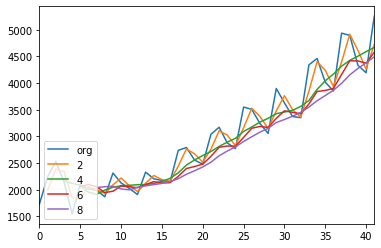

In [15]:
coco.Sales.plot(label="org")
for i in range(2,10,2):
    coco["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)
    

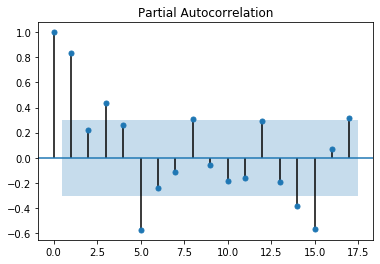

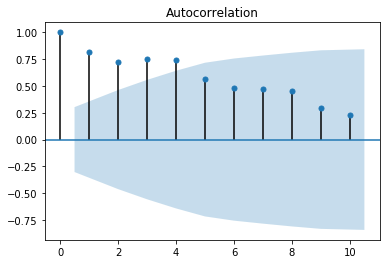

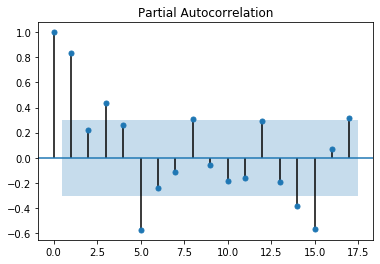

In [19]:
tsa_plots.plot_acf(coco.Sales,lags=10)
tsa_plots.plot_pacf(coco.Sales)

In [21]:
Train = coco.head(48)
Test =coco.tail(12)

In [22]:
def MAPE(pred,org):
    temp = np.abs((pred-org))*100/org
    return np.mean(temp)

In [23]:
# Simple Exponential Method
ses_model = SimpleExpSmoothing(Train["Sales"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales) # 9.76

9.68102621291766

In [24]:
# Holt method 
hw_model = Holt(Train["Sales"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Sales) # 9.82

10.805040304897148

In [25]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=4,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales)# 3.10

3.2286108955016632

In [26]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=4).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales) # 2.35

2.8845534968779045

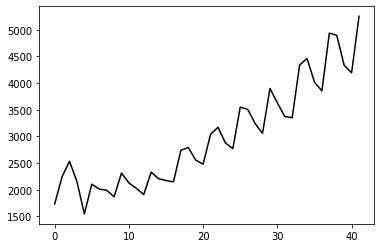

In [28]:
# Visualization of Forecasted values for Test data set using different methods 
plt.plot(Train.index, Train["Sales"], label='Train',color="black")

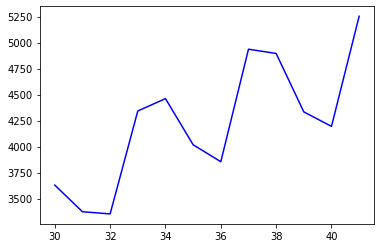

In [29]:
plt.plot(Test.index, Test["Sales"], label='Test',color="blue")

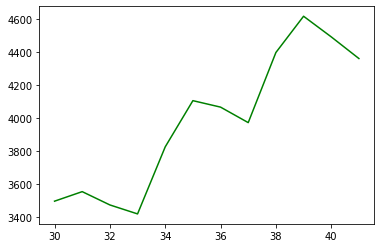

In [30]:
plt.plot(pred_ses.index, pred_ses, label='SimpleExponential',color="green")

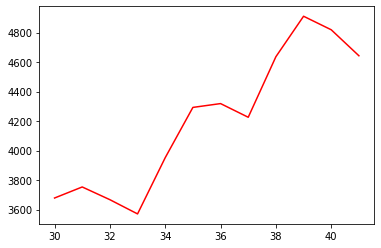

In [31]:
plt.plot(pred_hw.index, pred_hw, label='Holts_winter',color="red")

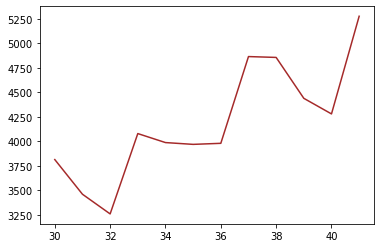

In [32]:
plt.plot(pred_hwe_add_add.index,pred_hwe_add_add,label="HoltsWinterExponential_1",color="brown")

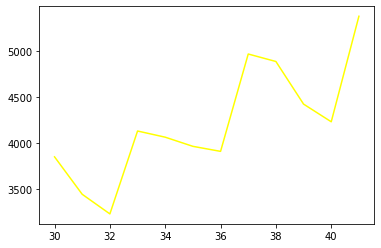

In [33]:
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="HoltsWinterExponential_2",color="yellow")